In [36]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

In [ ]:
import sys
sys.path.append('../../')

from utils.DataLoader import load_data

cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

train_df, test_df = load_data(
    train_path='../../data/train_8000_final.p',
    test_path='../../data/test_2000_final.p',
    cols_to_drop=cols_to_drop
)


0-0    6057
0-1    1856
1-0      56
1-1      31
Name: count, dtype: int64


In [39]:
#background: season, policy, self-empl
#diagnosis: pneu, cold
#underlying condition: asthma, smoking, COPD
#symptoms: dyspnea, cough, pain, fever, nasal

BN = BayesianNetwork([
    ('smoking', 'COPD'),
    ('smoking', 'cough'),
    ('smoking', 'dysp'),
    ('asthma', 'dysp'),
    ('asthma', 'pneu'),
    ('asthma', 'cough'),
    ('hay_fever', 'dysp'),
    ('hay_fever', 'nasal'),
    ('COPD', 'pneu'),
    ('COPD', 'dysp'),
    ('COPD', 'cough'),
    ('COPD', 'pain'),
    ('winter', 'pneu'),
    ('winter', 'inf'),
    ('pneu', 'dysp'),
    ('pneu', 'cough'),
    ('pneu', 'pain'),
    ('pneu', 'fever'),
    ('inf', 'cough'),
    ('inf', 'pain'),
    ('pneu', 'fever'),
    ('pneu', 'nasal'),
    ('cough', 'pain')
])

def BN_model_train(train_df, test_df, target):
    print(f"🔹 Đang chạy với target: {target}")

    # Chuyển đổi nhãn thành 0 và 1
    train_df[target] = train_df[target]
    test_df[target] = test_df[target]

    # Huấn luyện mô hình
    BN.fit(train_df, estimator=BayesianEstimator)

    # Khởi tạo suy diễn
    inference = VariableElimination(BN)

    # Dự đoán trên tập test
    test_features = test_df.drop(columns=[target])
    y_true = test_df[target].values
    y_pred = np.array([
        inference.query(variables=[target], evidence=row.to_dict()).values[1]  
        for _, row in test_features.iterrows()
    ])

    # Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Vẽ đồ thị
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()

    return BN

SEASON + CLINICAL + SYMPTOMS

🔹 Đang chạy với target: pneu


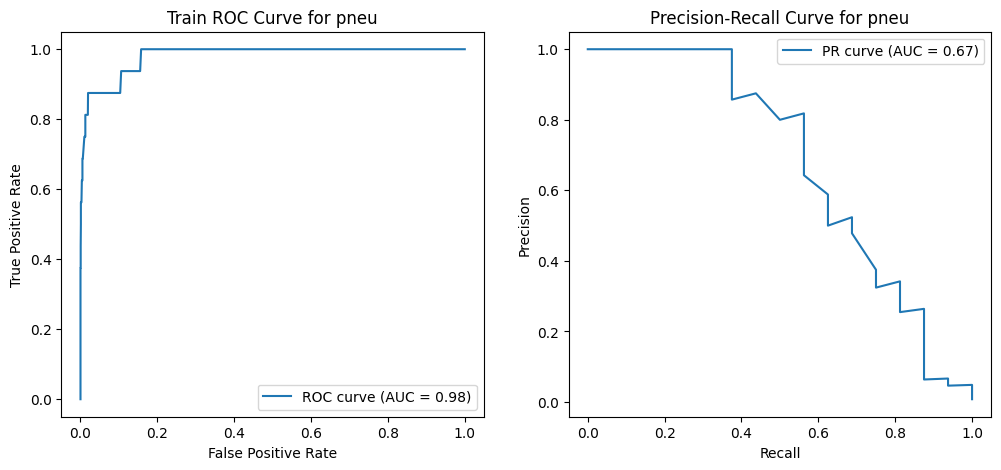

🔹 Đang chạy với target: inf


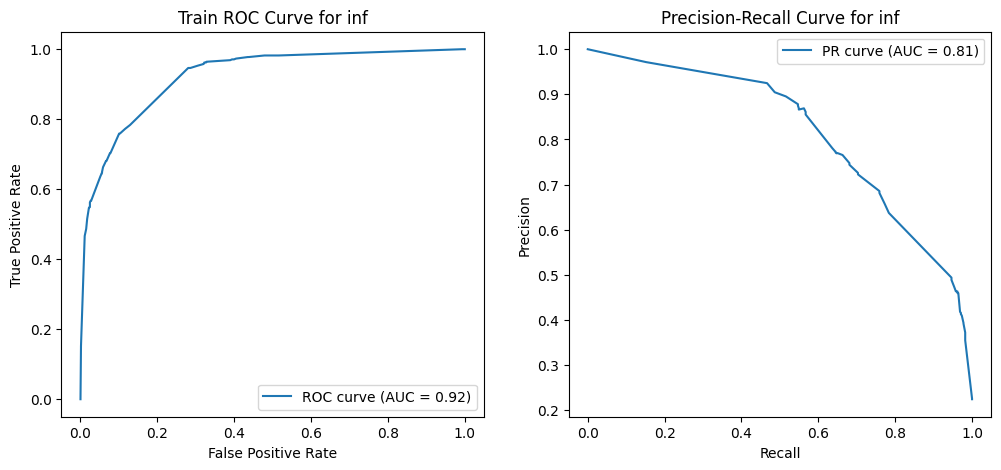

In [40]:
targets = ["pneu", "inf"]
BN_models = {
    'pneu': BN_model_train(train_df.iloc[:, :12], test_df.iloc[:, :12], "pneu"),
    'inf': BN_model_train(train_df.iloc[:, :12], test_df.iloc[:, :12], "inf")
}

In [41]:
print(BN_models['pneu'].get_cpds("pneu"))


+---------+--------------------+-----+---------------------+
| COPD    | COPD(0)            | ... | COPD(1)             |
+---------+--------------------+-----+---------------------+
| asthma  | asthma(0)          | ... | asthma(1)           |
+---------+--------------------+-----+---------------------+
| winter  | winter(0)          | ... | winter(1)           |
+---------+--------------------+-----+---------------------+
| pneu(0) | 0.9947247096373792 | ... | 0.9528301886792453  |
+---------+--------------------+-----+---------------------+
| pneu(1) | 0.0052752903626208 | ... | 0.04716981132075472 |
+---------+--------------------+-----+---------------------+


SEASON

In [44]:
BN2 = BayesianNetwork([
    ('winter', 'pneu'),
    ('winter', 'inf')
])

def BN_model_train2(train_df, test_df, target):
    print(f"🔹 Đang chạy với target: {target}")

    # Chuyển đổi nhãn thành 0 và 1
    train_df[target] = train_df[target]
    test_df[target] = test_df[target]

    # Huấn luyện mô hình
    BN2.fit(train_df, estimator=BayesianEstimator)

    # Khởi tạo suy diễn
    inference = VariableElimination(BN2)

    # Dự đoán trên tập test
    test_features = test_df.drop(columns=[target])
    y_true = test_df[target].values
    y_pred = np.array([
        inference.query(variables=[target], evidence=row.to_dict()).values[1]  
        for _, row in test_features.iterrows()
    ])

    # Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Vẽ đồ thị
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()

    return BN2

🔹 Đang chạy với target: pneu


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_12148\3559638498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_12148\3559638498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


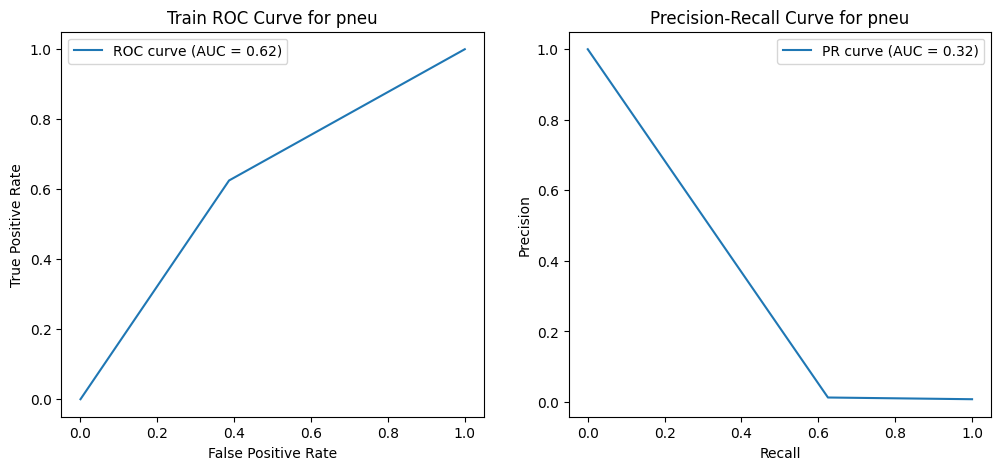

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_12148\3559638498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target] = train_df[target]
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_12148\3559638498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target] = test_df[target]


🔹 Đang chạy với target: inf


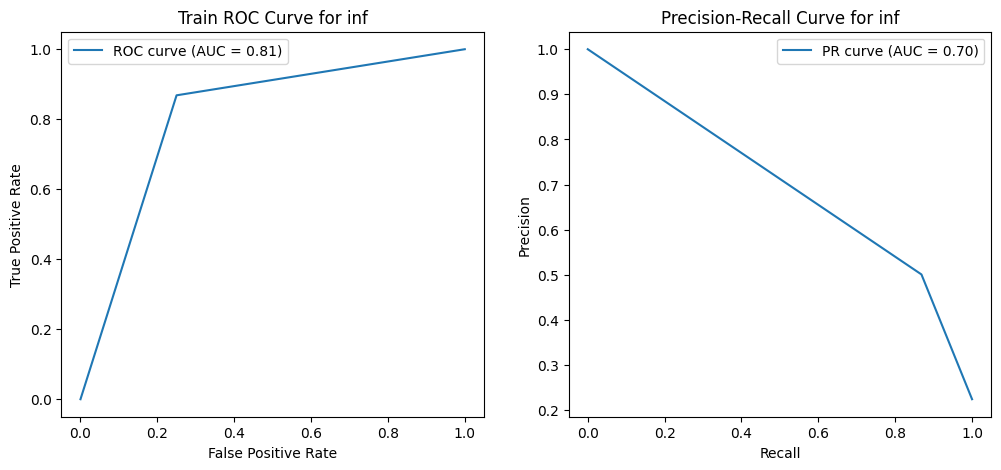

In [45]:
targets = ["pneu", "inf"]

BN_models2 = {
    'pneu': BN_model_train2(train_df[["winter", "pneu", "inf"]], test_df[["winter", "pneu", "inf"]], "pneu"),
    'inf': BN_model_train2(train_df[["winter", "pneu", "inf"]], test_df[["winter", "pneu", "inf"]], "inf")
}
